# Prototype for SGS model calculations

## Preamble

In [1]:
from pathlib import Path
import xarray as xr
import time
from pint import UnitRegistry
ureg = UnitRegistry() #use to parse resolutions
import numpy as np
# import os
# os.chdir('src/')

%load_ext autoreload
%autoreload 2
#dev env

In [2]:
import matplotlib.pyplot as plt

# IO

In [7]:
ext_path = Path('/Volumes/Work/NERC_postdoc/online_datatest')
# ext_path = Path('/Users/dv270/NERC_postdoc/online_datatest/')
rel_path = 'CBL/MONC_LES/'

## Read MONC LES files

In [8]:

base_fields_dict = {
    "u": "u",
    "v": "v",
    "w": "w",
    "th": "theta",
}

In [9]:
def read_monc_field_files(
    base_dir: Path | str, prefix: str
) -> xr.Dataset:
    """combine a list of output field files: will search for will be expanded to "`base_dir`/`prefix`*.nc"

    :param base_dir: base directory containing all files
    :param prefix: prefix for all filenames -- 
    :return: `xarray.Dataset` with all available variables
    """

    fname_pattern = f"{prefix}*.nc"
    print(f"Reading {base_dir}/{fname_pattern}")
    # turn Path.glob() into list because of incomplete typehints of xr.open_mfdataset
    dataset = xr.open_mfdataset(list(Path(base_dir).glob(fname_pattern)), chunks={})
    return dataset


In [10]:
resolution = '5m'
#read MONC stasth files: data
simulation_stag = read_monc_field_files(ext_path / rel_path, "diagnostics_5m_3d_ts_13200")


Reading /Volumes/Work/NERC_postdoc/online_datatest/CBL/MONC_LES/diagnostics_5m_3d_ts_13200*.nc


In [11]:
simulation_stag

<xarray.Dataset>
Dimensions:              (time_series_600_600: 1, x: 960, y: 960, z: 400,
                          zn: 400, number_options: 692, kvp: 2)
Coordinates:
  * time_series_600_600  (time_series_600_600) float64 1.261e+04
  * zn                   (zn) float64 -2.506 2.506 7.519 ... 1.992e+03 1.997e+03
  * z                    (z) float64 0.0 5.013 10.03 ... 1.995e+03 2e+03
Dimensions without coordinates: x, y, number_options, kvp
Data variables:
    w                    (time_series_600_600, x, y, z) float64 dask.array<chunksize=(1, 960, 960, 400), meta=np.ndarray>
    v                    (time_series_600_600, x, y, z) float64 dask.array<chunksize=(1, 960, 960, 400), meta=np.ndarray>
    u                    (time_series_600_600, x, y, z) float64 dask.array<chunksize=(1, 960, 960, 400), meta=np.ndarray>
    th                   (time_series_600_600, x, y, zn) float64 dask.array<chunksize=(1, 960, 960, 400), meta=np.ndarray>
    p                    (time_series_600_600, x, y, zn) float64 dask.array<chunksize=(1, 960, 960, 400), meta=np.ndarray>
    tracer_rad1          (time_series_600_600, x, y, zn) float64 dask.array<chunksize=(1, 960, 960, 400), meta=np.ndarray>
    options_database     (number_options, kvp) |S150 dask.array<chunksize=(692, 2), meta=np.ndarray>
Attributes:
    title:                         All diagnostic values
    created:                       5/3/2020 12:7:42
    MONC time:                     13211.4736328125
    MONC timestep:                 153300
    Diagnostic write frequency:    1200.0
    Previous diagnostic write at:  12009.5908203125

### Preprocess simulation (rename and put on a single grid)

In [12]:

from sgs_tools.geometry.staggered_grid import (interpolate_to_grid, 
                                              )

In [13]:
%%time 
#interpolate all vars to a cell-centred grid
simulation = interpolate_to_grid(simulation_stag, 
                                 coord_map = {'zn' : simulation_stag['z']},
                                 drop_coords=False)


CPU times: user 4.57 ms, sys: 924 µs, total: 5.5 ms
Wall time: 5.2 ms


In [14]:
#add time in minutes
simulation = simulation.assign_coords({'time_min' : simulation['time_series_600_600']/60})
simulation['time_min'].attrs['units'] = 'min'
#time in hours
simulation = simulation.assign_coords({'time' : simulation['time_min']/60})
simulation['time'].attrs['units'] = 'h'

In [15]:
#add horizontal cell size to simulation
for dim in ['x', 'y']:
    delta = ureg(resolution).to('m').magnitude    
    simulation[f'd{dim}'] = delta
    simulation[dim] = np.linspace(0, simulation[dim].shape[0]*delta , simulation[dim].shape[0], endpoint=False )

if (simulation['dx'] == simulation['dy']):
    simulation['dhor'] = simulation['dx']
else:
    print ('Warning! horiztonally anisotropic grid')


In [16]:
simulation

<xarray.Dataset>
Dimensions:              (time_series_600_600: 1, x: 960, y: 960, z: 400,
                          number_options: 692, kvp: 2)
Coordinates:
  * time_series_600_600  (time_series_600_600) float64 1.261e+04
    zn                   (z) float64 0.0 5.013 10.03 ... 1.995e+03 2e+03
  * z                    (z) float64 0.0 5.013 10.03 ... 1.995e+03 2e+03
    time_min             (time_series_600_600) float64 210.1
    time                 (time_series_600_600) float64 3.502
  * x                    (x) float64 0.0 5.0 10.0 ... 4.79e+03 4.795e+03
  * y                    (y) float64 0.0 5.0 10.0 ... 4.79e+03 4.795e+03
Dimensions without coordinates: number_options, kvp
Data variables:
    w                    (time_series_600_600, x, y, z) float64 dask.array<chunksize=(1, 960, 960, 400), meta=np.ndarray>
    v                    (time_series_600_600, x, y, z) float64 dask.array<chunksize=(1, 960, 960, 400), meta=np.ndarray>
    u                    (time_series_600_600, x, y, z) float64 dask.array<chunksize=(1, 960, 960, 400), meta=np.ndarray>
    th                   (time_series_600_600, x, y, z) float64 dask.array<chunksize=(1, 960, 960, 400), meta=np.ndarray>
    p                    (time_series_600_600, x, y, z) float64 dask.array<chunksize=(1, 960, 960, 400), meta=np.ndarray>
    tracer_rad1          (time_series_600_600, x, y, z) float64 dask.array<chunksize=(1, 960, 960, 400), meta=np.ndarray>
    options_database     (number_options, kvp) |S150 dask.array<chunksize=(692, 2), meta=np.ndarray>
    dx                   int64 5
    dy                   int64 5
    dhor                 int64 5
Attributes:
    title:                         All diagnostic values
    created:                       5/3/2020 12:7:42
    MONC time:                     13211.4736328125
    MONC timestep:                 153300
    Diagnostic write frequency:    1200.0
    Previous diagnostic write at:  12009.5908203125

# Compute dynamic Smagorinsky model coefficient at one scale
* TODO -- try to incroporate monc_utils

In [17]:
from sgs_tools.geometry.staggered_grid import compose_vector_components_on_grid
from sgs_tools.physics.fields import strain_from_vel

## Momentum coefficient

In [21]:
from sgs_tools.sgs.filter import IdentityFilter, box_kernel, Filter, weight_gauss_3d
from sgs_tools.sgs.Smagorinsky import SmagorinskyVelocityModel, DynamicSmagorinskyVelocityModel

# from sgs_tools.sgs.dynamic_model import GermanoIdentity


In [19]:
%%time
#ensure velocity components are co-located
simple_dims = ['x', 'y', 'z'] # coordinates already exist in simulation
vel = compose_vector_components_on_grid([simulation['u'], simulation['v'], simulation['w']],
                                        simple_dims, name = 'vel',
                                        vector_dim = 'c1')

CPU times: user 6.67 ms, sys: 775 µs, total: 7.44 ms
Wall time: 7.05 ms


In [23]:
%%time
#Smagorinsky momentum model
sij = strain_from_vel(vel, space_dims= simple_dims,
                      vec_dim = 'c1', new_dim = 'c2', make_traceless =True,
                      )
SmagVel = SmagorinskyVelocityModel(vel, sij,  cs = 1, dx = simulation['dhor'])
dyn_smag_vel = DynamicSmagorinskyVelocityModel(SmagVel)
# del sij

CPU times: user 23.4 ms, sys: 991 µs, total: 24.3 ms
Wall time: 24 ms


In [84]:
z_slice = slice(10,40, 5)
t_slice = slice(4, 5)
c1 = 2
c2 = 2

sij.isel(c1 = c1, c2 = c2, time_series_600_600 = t_slice, z=z_slice).plot(col='z',robust=True)
plt.suptitle("M box", y = 1.01)

# sij_staggered.isel(c1 = c1, c2 = c2, t_0 = t_slice, z=z_slice).plot(col='z',robust=True)
# plt.suptitle("M box", y = 1.01)


# sij.isel(c1 = 0, c2 = 0, t_0 = t_slice, z=z_slice).plot(col='z',robust=True)
# plt.suptitle("M box", y = 1.01)

# Mij_gauss.isel(c1 = 0, c2 = 0, t_0 = t_slice, z=z_slice).plot(col='z',robust=True)
# plt.suptitle("M gauss", y = 1.01)

# Lij_box.isel(c1 = 0, c2 = 0, t_0 = t_slice, z=z_slice).plot(col='z',robust=True)
# plt.suptitle("L box", y = 1.01)

# Lij_gauss.isel(c1 = 0, c2 = 0, t_0 = t_slice, z=z_slice).plot(col='z',robust=True)
# plt.suptitle("L gauss", y = 1.01)



KeyboardInterrupt



In [24]:
box_3delta_hor = Filter(box_kernel([3,3]), ['x','y'])
box_5delta_hor = Filter(box_kernel([5,5]), ['x','y'])
gauss_3delta_hor = Filter(weight_gauss_3d, ['x','y'])

In [ ]:
#compare with diagnostic snorm
for Smag in SmagVel, :
    snorm_3deltar = Smag.snorm(gauss_3delta_hor)
    snorm_3deltar.isel(t_0 = slice(4, 5), z = slice(10,40, 5)).plot(col='z',robust=True, add_colorbar=True)
    plt.show()
simulation['s2d'].isel(t = slice(3, 4), z = slice(10,40, 5)).plot(col='z',robust=True, add_colorbar = True) 
plt.show()

for Smag, lbl in zip([SmagVel, ], ['cent', 'stag']):
    snorm_3deltar = Smag.snorm(gauss_3delta_hor) 
    snorm_3deltar.isel(t_0 = slice(4, 5), z = slice(5, None)).mean(['x', 'y']).plot(y = 'z', label = lbl)
simulation['s2d'].isel(t = slice(3, 4), z = slice(5, None)).mean(['x', 'y']).plot(y='z', label ='sim') 
plt.legend()
plt.show()

# print(simulation['s2d'].isel(t=-1).t.data)
# print(snorm_3deltar.isel(t_0=-1).t_0.data)

# print(simulation['s2d'].isel(t=-1).t.data)
# print(snorm_3deltar.isel(t_0=-1).t_0.data)

plt.show()

In [ ]:
%%time
#compute Germano tensors
# tau_ij = SmagVel.sgs_tensor() # just for reference
# Mij_box = SmagVel.M_Germano_tensor(box_3delta_hor)
# Lij_box = SmagVel.L_Germano_tensor(box_3delta_hor)

Mij_gauss = SmagVel.M_Germano_tensor(gauss_3delta_hor)
Lij_gauss = SmagVel.L_Germano_tensor(gauss_3delta_hor)

In [ ]:
z_slice = slice(10,40, 5)
t_slice = slice(4, 5)

# tau_ij.isel(c1 = 0, c2 = 0, t_0 = t_slice, z=z_slice).plot(col='z',robust=True)
# plt.suptitle("tau grid", y = 1.01)

# Mij_box.isel(c1 = 0, c2 = 0, t_0 = t_slice, z=z_slice).plot(col='z',robust=True)
# plt.suptitle("M box", y = 1.01)

Mij_gauss.isel(c1 = 0, c2 = 0, t_0 = t_slice, z=z_slice).plot(col='z',robust=True)
plt.suptitle("M gauss", y = 1.01)

# Lij_box.isel(c1 = 0, c2 = 0, t_0 = t_slice, z=z_slice).plot(col='z',robust=True)
# plt.suptitle("L box", y = 1.01)

Lij_gauss.isel(c1 = 0, c2 = 0, t_0 = t_slice, z=z_slice).plot(col='z',robust=True)
plt.suptitle("L gauss", y = 1.01)


$\nu =  -2 C_{il}  S_{jl} C_{li}$

$\nu_{ij} =  -2 \sqrt{C_{il}  S_{lm} S_{mk} C_{ki}}$

#### Isotropic $c_s = \frac{\langle L_{ij} M_{ji} \rangle }{\langle M_{ij} M_{ji} \rangle }$

#### Diagonal $({c_s})_{\alpha} = \frac{\langle L_{i \alpha} M_{\alpha i} \rangle }{\langle M_{i \alpha } M_{\alpha i} \rangle }$, where summation is only over ${i}$

In [26]:
from sgs_tools.sgs.dynamic_coefficient import dynamic_coeff

In [27]:
def cs_matrix(Mij, Lij, regularization_filter):
    #since Lij and Mij are both symmetric w.r.t c1, c2, we can choose either one
    contract_dims = ['c2']
    MM = Mij * Mij
    
    #since Lij and Mij are both symmetric we don't need to transpose
    LM = Mij * Lij
    
    LM_reg = regularization_filter.filter(LM)
    MM_reg = regularization_filter.filter(MM)
    
    return  LM_reg / MM_reg

In [28]:
def clipped_ratio (num, denom, epsilon):
    return max(num/max(denom, epsilon), epsilon)

In [31]:
%%time 
cs_iso_gauss = dynamic_coeff(dyn_smag_vel, gauss_3delta_hor, box_3delta_hor, ['c1', 'c2'])
cs_iso_box = dynamic_coeff(dyn_smag_vel, box_3delta_hor, box_3delta_hor, ['c1', 'c2'])

cs_iso_gauss = cs_iso_gauss.where(cs_iso_gauss>0, 0)
cs_iso_box = cs_iso_box.where(cs_iso_box>0, 0)

CPU times: user 100 ms, sys: 1.42 ms, total: 101 ms
Wall time: 102 ms


In [ ]:
%%time
# z = slice(10,40, 5)
t_slice = slice(0)
cs_iso_gauss_data = cs_iso_gauss.isel(time_series_600_600 = t_slice).mean(dim=['x', 'y'])
cs_iso_gauss_data.plot(y='z',  color = 'r', label='iso gauss local 2d')

plt.legend()

In [ ]:
cs_iso_gauss_data.plot(y='z',  color = 'r', label='iso gauss local 2d')

plt.legend()

In [32]:
%%time 
cs_diag_gauss = dynamic_coeff(dyn_smag_vel, gauss_3delta_hor, box_3delta_hor, ['c1'])
cs_diag_box = dynamic_coeff(dyn_smag_vel, box_3delta_hor, box_3delta_hor, ['c1',])

cs_diag_gauss = cs_diag_gauss.where(cs_diag_gauss>0, 0)
cs_diag_box = cs_diag_box.where(cs_diag_box>0, 0)

CPU times: user 104 ms, sys: 1.81 ms, total: 106 ms
Wall time: 106 ms


In [ ]:
%%time
# z = slice(10,40, 5)
t_slice = slice(0)
cs_diag_gauss_data = cs_diag_gauss.isel(time_series_600_600 = t_slice).mean(dim=['x', 'y'])


In [ ]:
cs_diag_gauss_data.plot(y='z',  color = 'r', label='diag gauss local 2d')

plt.legend()

In [66]:
%%time 
cs_matrix_gauss = cs_matrix(Mij_gauss, Lij_gauss, box_3delta_hor)
# cs_matrix_box = cs_matrix(Mij_box, Lij_box, box_3delta_hor)

cs_matrix_gauss = cs_matrix_gauss.where(cs_matrix_gauss>0, 0)
# cs_matrix_box = cs_matrix_box.where(cs_matrix_box>0, 0)

CPU times: user 23.6 s, sys: 8.54 s, total: 32.2 s
Wall time: 42.8 s


NameError: name 'cs_matrix_gauss' is not defined

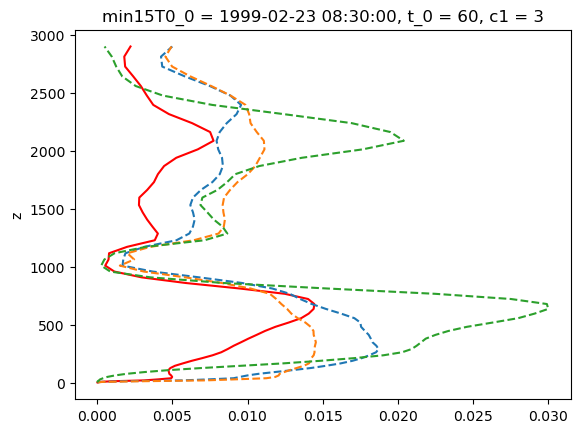

In [47]:
cs_iso_gauss.isel(t_0 = t_slice).mean(dim=['x', 'y']).plot(y='z', ls='-', color = 'r', label='box iso 2d')

for c1 in range(3):
    c, = cs_diag_gauss.isel(t_0 = t_slice, c1 = c1).mean(dim=['x', 'y']).plot(y='z', ls = '--', label = f'c_s idx {c1} ')


# for c1 in range(3):
#     for c2 in range(c1+1):
#         c, = cs_matrix_gauss.isel(t_0 = t_slice, c2 = c2, c1 = c1).mean(dim=['x', 'y']).plot(y='z', ls = ':', label = f'c_s idx {c1} {c2}')

# simulation['cs2d'].isel(t = 4).mean(dim=['x','y']).plot(y='z', color = 'gray', label='sim')
# plt.legend()

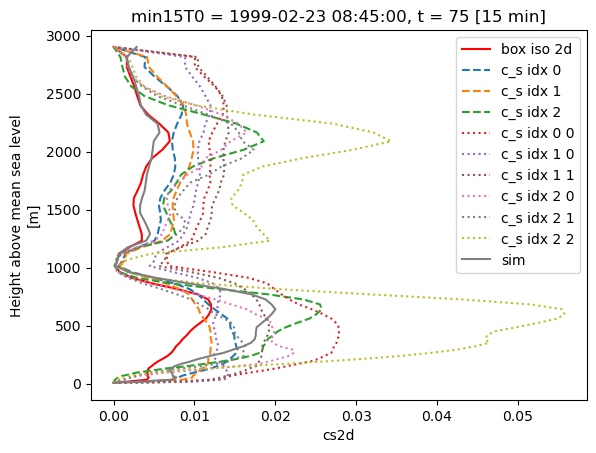

In [72]:
cs_stag_iso_gauss.isel(t_0 = t_slice).mean(dim=['x', 'y']).plot(y='z', ls='-', color = 'r', label='box iso 2d')

for c1 in range(3):
    c, = cs_stag_diag_gauss.isel(t_0 = t_slice, c1 = c1).mean(dim=['x', 'y']).plot(y='z', ls = '--', label = f'c_s idx {c1} ')


for c1 in range(3):
    for c2 in range(c1+1):
        c, = cs_stag_matrix_gauss.isel(t_0 = t_slice, c2 = c2, c1 = c1).mean(dim=['x', 'y']).plot(y='z', ls = ':', label = f'c_s idx {c1} {c2}')

simulation['cs2d'].isel(t = 4).mean(dim=['x','y']).plot(y='z', color = 'gray', label='sim')
plt.legend()

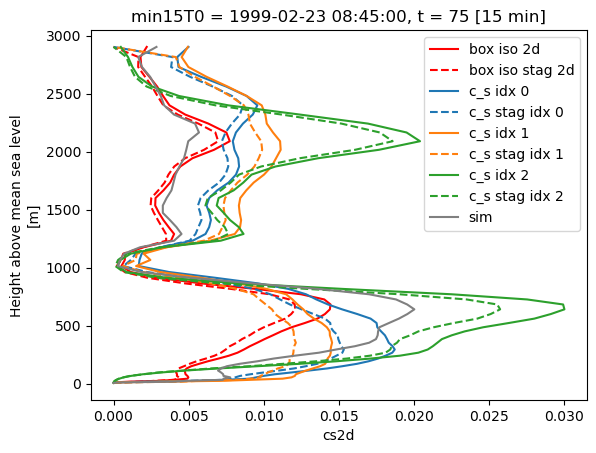

In [60]:
cs_iso_gauss.isel(t_0 = t_slice).mean(dim=['x', 'y']).plot(y='z', ls='-', color = 'r', label='box iso 2d')
cs_stag_iso_gauss.isel(t_0 = t_slice).mean(dim=['x', 'y']).plot(y='z', ls='--', color='r', label='box iso stag 2d')

for c1 in range(3):
    c, = cs_diag_gauss.isel(t_0 = t_slice, c1 = c1).mean(dim=['x', 'y']).plot(y='z', label = f'c_s idx {c1} ')
    cs_stag_diag_gauss.isel(t_0 = t_slice, c1 = c1).mean(dim=['x', 'y']).plot(y='z', ls = '--',  color = c.get_color(), label = f'c_s stag idx {c1} ')

simulation['cs2d'].isel(t = 4).mean(dim=['x','y']).plot(y='z', color = 'gray', label='sim')
plt.legend()

In [ ]:
cs_stag_diag_gauss.isel(t = slice).mean(dim=['x', 'y']).plot(row='c1',robust=True)

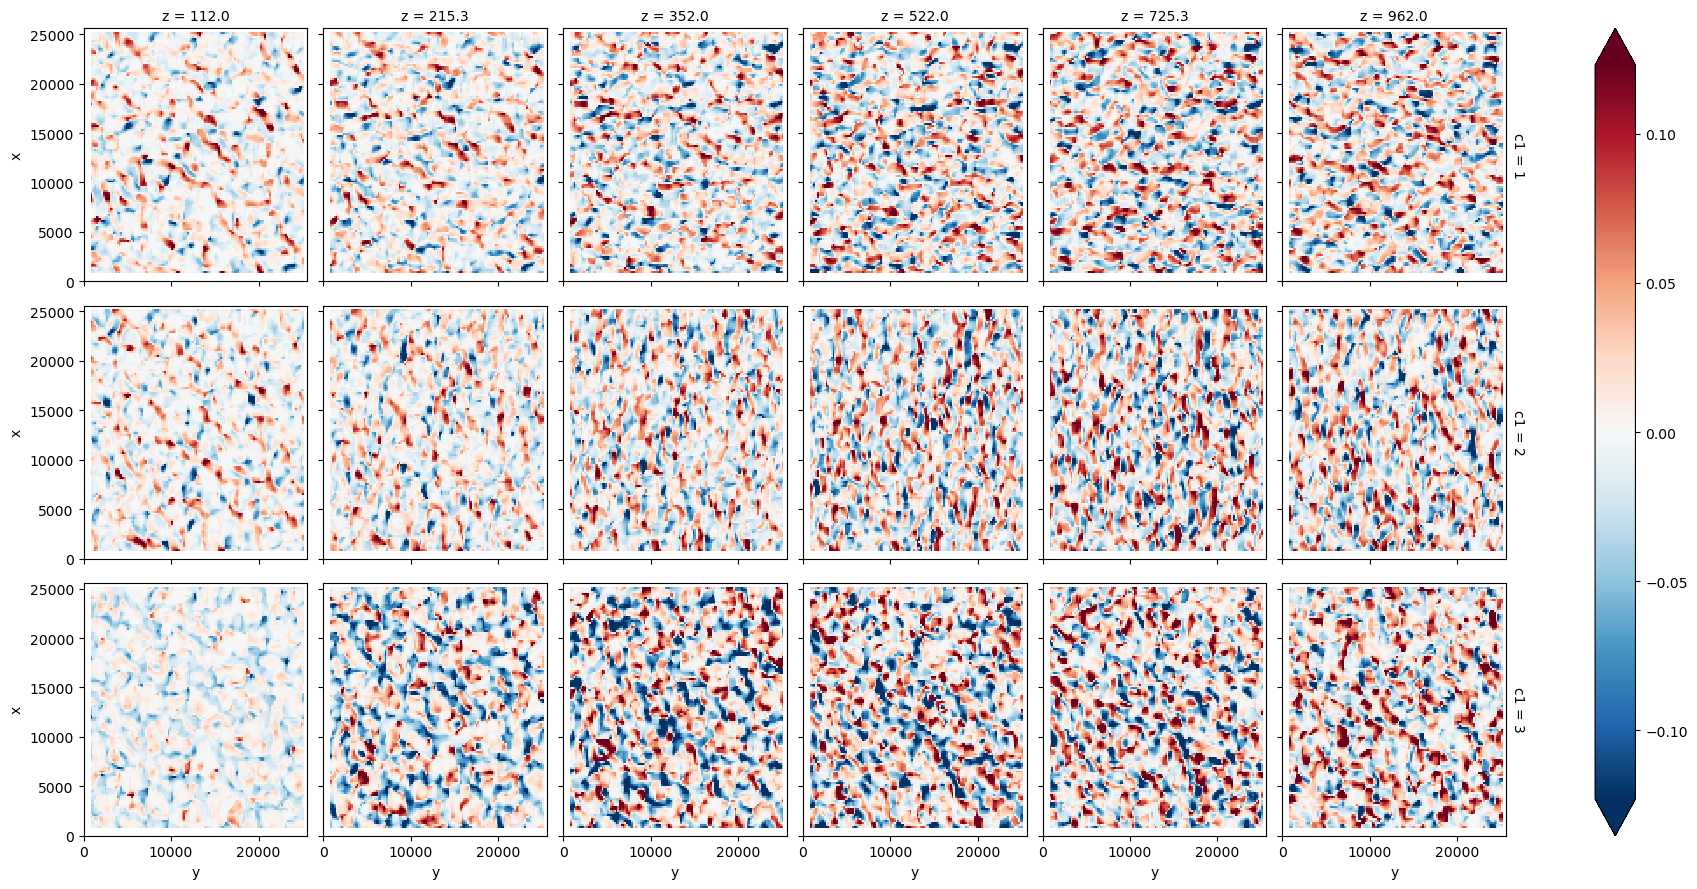

In [135]:
cs_diag_box.isel(t_0 = -1, z = slice(10,40, 5)).plot(col='z',row='c1',robust=True)

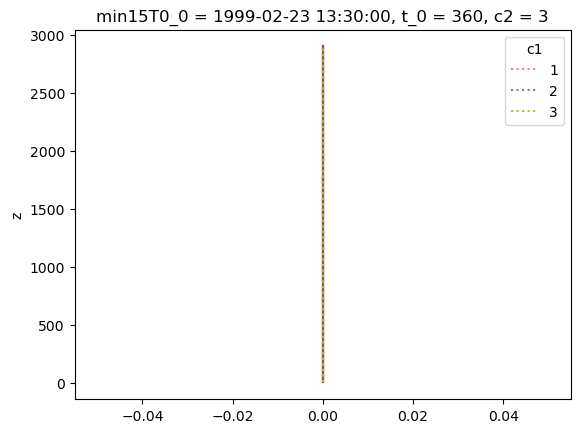

In [88]:
cs_matrix_gauss.isel(t_0 = -1, c2 = 0).mean(dim=['x', 'y']).plot(y='z', hue = 'c1', ls='--')
cs_matrix_gauss.isel(t_0 = -1, c2 = 1).mean(dim=['x', 'y']).plot(y='z', hue = 'c1', ls='-')
cs_matrix_gauss_clipped.isel(t_0 = -1, c2 = 2).mean(dim=['x', 'y']).plot(y='z', hue = 'c1', ls=':')

In [91]:
cs_diag_box_clipped.isel(t_0 = -1).mean(dim=['x', 'y']).plot(y='z', hue = 'c1', ls='--')
cs_iso_box_clipped.isel(t_0 = -1).mean(dim=['x', 'y']).plot(y='z', color='gray', ls=':')
# # cs_iso_gauss.isel(t_0 = -1).mean(dim=['x', 'y']).plot(y='z', color = 'b', label='gauss local')

# cs_iso_box_clipped.isel(t_0 = -1).mean(dim=['x', 'y']).plot(y='z', ls='--', color = 'r', label='box local clipped')
# # cs_iso_box.isel(t_0 = -1).mean(dim=['x', 'y']).plot(y='z', ls='--', color='b', label='box local')


simulation['cs2d'].isel(t=-1).mean(dim=['x','y']).plot(y='z', color = 'k', label='sim')
plt.legend()

NameError: name 'cs_diag_box_clipped' is not defined

In [ ]:
simulation['vertical_heat_flux'] = vertical_heat_flux(simulation['w'], simulation['theta'], ['x', 'y'])